# NER using SPACY and BERT on medical transcriptions

# Purpose
Take a Medical transcription data set and identify named entities from that data set. Named entities are typically "tags" that provide more contextual meaning to different words in a natural language corpus. For example "tools" imply collection of items like "hammer", "nail", "saw", etc. Similarly, "organization" implies a collection of commercial and non-profit companies like "Google", "Netflix", "FDA", etc.

As applicable to medical transcription, a perusal of the data set (presented in upcoming sections) provide for certain groups that are fairly distinct from other "biological" terms (though there maybe some overlap). Typically medical terms can be classified as symptoms, conditions (or ailments), affected parts, etc. 

Such classification is important to analyze more macro trends - for example, how many symptoms are typically associated with conditions? Is there a relationship between affected parts and certain conditions or are some procedures more commonly used than others given certain conditions? While the topic of such analysis and relationship extraction is not the focus of these models, named entity recognition (NER) models address the first part of the problem, i.e., first identifying and classifying the given corpus into different domain-specific tags.

So in these models, we will take the same set of medical transcription data, but illustrate how another NLP task of named-entity recognition (NER) can be applied for the same.

In [2]:
import pkgutil
import importlib.util
import sys
import os
import argparse
import ast

_test_individual_blocks = True
required_modules_list = [["torch", ""],
                             ["pandas", ""],
                             ["numpy", ""],
                             ["sklearn", ""],
                             ["matplotlib", ""],
                             ["nltk", ""],
                             ["spacy", "3.7.5"],
                             ["tqdm", ""]]
# Spacy version 3.8.7 which is the latest does not work with NVCR.IO Tensorflow: 25.02-tf2-py3

In [3]:
skip_spacy_model = False
skip_spacy_model_download = True
skip_bert_model = False

In [4]:
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if not eval(line):  # Execute cell only if condition is False
        return get_ipython().run_cell(cell)

In [5]:
%%skip_if skip_spacy_model_download

!python -m spacy download en_core_web_lg

In [6]:
def check_module_availability():
    print("Checking Package Availability:")
    for module_name, version in required_modules_list:
        if (spec := importlib.util.find_spec(module_name)) is not None:
            print("\t\'%s\' is available" % (module_name))            
        else:
            print("\tCannot find \'%s\'" %(module_name))
            return False
    return True

if check_module_availability() is False:
    exit()



Checking Package Availability:
	'torch' is available
	'pandas' is available
	'numpy' is available
	'sklearn' is available
	'matplotlib' is available
	'nltk' is available
	'spacy' is available
	'tqdm' is available


In [7]:
print("Importing Libraries after checking presence")
from tqdm import tqdm
import pandas as pd
from string import punctuation
import numpy as np
import torch
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk, sent_tokenize
from nltk.tree import Tree
from nltk.corpus import stopwords
from collections import Counter


Importing Libraries after checking presence


In [8]:
def check_gpu_availability():
   print("Checking for GPU availability:")
   if torch.cuda.is_available():
      print("GPU is available!")
      print(f"Number of GPUs: {torch.cuda.device_count()}")
      print(f"Current GPU device name: {torch.cuda.get_device_name(0)}") # Get name of the first GPU
   else:
      print("GPU is not available. PyTorch will use CPU.")
    
check_gpu_availability()

Checking for GPU availability:
GPU is available!
Number of GPUs: 1
Current GPU device name: NVIDIA GeForce RTX 4070 Ti


## Data set overview
The below section provides a quick preview of the data file that we have. As can be seen on this, it is clear that the dataset has multiple columns. Of these, for the NER task, we will use the transcrption column.  

In [ ]:
sample_df = pd.read_excel('dataset/mtsamples.xlsx').dropna()
sample_df.rename(columns ={'Unnamed: 0': 'id'}, inplace = True)
print(f"Dataset Columns:\n\t{sample_df.columns}")
print(f"Dataset has {len(sample_df)} rows")


Dataset Columns:
	Index(['id', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')
Dataset has 3898 rows


## High level approach
1. Annotate Data: Prepare 2x(5) sentences such that there are atleast 50 labels of each type.
2. Build Model:
    1. Train Model with Training set from above.
    2. Test Model based on Training.
    3. Run predition on a new set of inputs.
3. Use 2 models for NER:
    1. Spacy based model
    2. BERT based model


## Annotating data
* To annotate data, convert dataframe (Transcription) into the CoNLL BIO format, i.e.,:
    * Entity that at the beginning of a potential multi-word entity: Beginning (B)
    * Entity that is part of a multi-word entity, but not at the beginning: Inside (I)
    * Any pord that is not an Entity: Outside (O)
* Use following 5 Labels for this project:
    * Affected Part (AP)
    * Symptiom (SYM)
    * Condition (COND)
    * Procedure (PROC)
    * Medication (MED)
    * Tool (TOOL)

The above implies that on this custom annotation, we will have a "B-AP", "I-AP", "B-SYM", "I-SYM", and so on as the label set. The next cell shows the actual labels used for these models.


In [10]:
id2label = {
    0: 'O',
    1: 'B-AP',
    2: 'I-AP',
    3: 'B-SYM',
    4: 'I-SYM',
    5: 'B-COND',
    6: 'I-COND', 
    7: 'B-PROC',
    8: 'I-PROC',
    9: 'B-MED',
    10: 'I-MED',
    11: 'B-TOOL',
    12: 'I-TOOL',
}

label2id = {
    'O'      :0,
    'B-AP'   :1,
    'I-AP'   :2,
    'B-SYM'  :3,
    'I-SYM'  :4,
    'B-COND' :5,
    'I-COND' :6, 
    'B-PROC' :7,
    'I-PROC' :8,
    'B-MED'  :9,
    'I-MED'  :10,
    'B-TOOL' :11,
    'I-TOOL' :12,
}


### Traditional approach of using NLTK and then manually tagging transcriptions.
In this approach we try annotatibe the training set using NLTK.
* Pros:
    * Easy to start
    * No sophisticated tools other than deciding the tokens and then manually perusing the transcripts.
* Cons:
    * Time consuming, exhausting and error prone. Each transcription had 20 plus lines!
    * Complexity in terms of technical (medical) jargon
    * Transcripts were quite complex and overpowering for someone not directly involved in these procedures.

In [11]:
nltk.download('popular')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download ('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))


def convert_to_bio(sent):
    tkns = word_tokenize(sent)
    pos_tags = pos_tag(tkns)
    named_entities = ne_chunk(pos_tags)

    BIO_tags = []
    for entity in named_entities:
        if isinstance(entity, Tree):
            entity_label = entity.label()
            for i, (token, pos) in enumerate(entity.leaves()):
                if i == 0:
                    BIO_tags.append((token, f"B-{entity_label}"))
                else:
                    BIO_tags.append((token, f"I-{entity_label}"))
        else:
            token, po = entity
            BIO_tags.append((token, "O"))
    return BIO_tags


sample_df.reset_index()

def create_first_pass_annotation(file_name, num, start_idx):
    sent_list = []
    for i in range(num):
        sent_list.append(str(convert_to_bio(sample_df.iloc[start_idx + i]['transcription'])))

    print(len(sent_list))
    with open(file_name, "w") as file:
        for i in range(len(sent_list)):
            file.write(sent_list[i] + '\n')

create_first_pass_annotation("nltk_tagging_train_file.txt", 25, 0)
create_first_pass_annotation("nltk_tagging_test_file.txt", 25, 100)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/bala/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/bala/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/bala/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/bala/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/bala/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/bala/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk

25
25


In [12]:
transcripts_as_sentences_df = pd.DataFrame(columns=['sentence', 'annotated_sentence'])

def convert_transcripts_to_sentences(paragraph, df):
    sentences = sent_tokenize(paragraph)
    tmp_df = pd.DataFrame(sentences, columns=['sentence'])
    tmp_df['annotated_sentence'] = ''
    df = pd.concat([df, tmp_df])
    return df

for i in range(100):
    transcripts_as_sentences_df = convert_transcripts_to_sentences(sample_df.iloc[i]['transcription'], transcripts_as_sentences_df)


train_size = int(0.67 * len(transcripts_as_sentences_df))
transcripts_as_sentences_test_df = transcripts_as_sentences_df.iloc[train_size:, :]
transcripts_as_sentences_train_df = transcripts_as_sentences_df.iloc[:train_size, :]


In [48]:
word_count_df = pd.DataFrame(columns=['transcription', 'word_counts'])

for idx, row in sample_df.iterrows():
    transcript = row['transcription']
    temp_df = pd.DataFrame({'transcription': [row['transcription']], 'word_counts': [len(word_tokenize(row['transcription']))]})
    # print(len(word_tokenize(row['transcription'])))
    # temp_df['sent_counts'] = len(word_tokenize(row['transcription']))
    word_count_df = pd.concat([word_count_df, temp_df])


In [54]:

print(f"Average Word Count across transcripts: {word_count_df['word_counts'].mean()}")
print(f"Min Word Count across transcripts: {word_count_df['word_counts'].min()}")
print(f"Max Word Count across transcripts: {word_count_df['word_counts'].max()}")


Average Word Count across transcripts: 479.668034889687
Min Word Count across transcripts: 3
Max Word Count across transcripts: 2222


### Chat GPT approach for annotation
While the above approach is useful for manual annotation, annotating the data set manually was identified as being extemely laborious. Instead, a simpler approach of generating the first pass annotation with the help of an LLM, ChatGPT / OpenAI in this case, resulted in a much quicker turnaround. The below section identifies the code to query the same automatically. The call to this is however commented to limit the number of queries to OpenAI.

In [ ]:
from openai import OpenAI
# client = OpenAI() # Add your credentials here

def query_openai(file_name, df):
    labeled_list = []
    sent_list = []
    for i in range(len(df)):
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",  # Or other models like gpt-4o, gpt-4
            messages=[
                {"role": "system", "content": """You are an annotation agent for medical transcriptions who will label entities following the BIO (Begin, Inside, Outside) scheme with the additional customization of:
                            1. Affected Part (AP) - hence labels such as B-AP or I-AP.
                            2. Symptom (SYM)-  hence labels such as B-SYM or I-SYM.
                            3. Condition (COND) - hence labels such as B-COND or I-COND.
                            4. Procedure (PROC) - hence labels such as B-PROC or I-PROC.0
                            5. Medication (MED) - hence labels such as B-MED or I-MED.
                            6. Tool (TOOL) - hence labels such as B-TOOL or I-TOOL.
                            Also, in the transcript, do not split words during tokenization.
                            Provide the output as a string in a single line with the following format:
                            [("Token", "label"), ("Token, "label")]. Verify that the labels are of the form B-AP, I-AP, etc.
                            Do not truncate the output as this will be used for modeling inputs."""},
                {"role": "user", "content": "Generate annotations for the following transcript: " + df.iloc[i, 0]}
            ]
        )
        df.iloc[i,1] = response.choices[0].message.content   
    df.to_excel(file_name)


# query_openai("dataset/train.xlsx", transcripts_as_sentences_train_df)
# query_openai("dataset/test.xlsx", transcripts_as_sentences_test_df)
    

In [ ]:

train_df = pd.read_excel('dataset/train.xlsx').dropna()
train_df_NER = train_df['annotated_sentence']
print(train_df.columns.tolist())
print(train_df.loc[0])

test_df = pd.read_excel('dataset/test.xlsx').dropna()
test_df_NER = test_df['annotated_sentence']
print(train_df.columns.tolist())
print(train_df.loc[0])



['Unnamed: 0', 'sentence', 'annotated_sentence']
Unnamed: 0                                                            0
sentence              SUBJECTIVE:,  This 23-year-old white female pr...
annotated_sentence    [("SUBJECTIVE", "O"), (":", "O"), (",", "O"), ...
Name: 0, dtype: object
['Unnamed: 0', 'sentence', 'annotated_sentence']
Unnamed: 0                                                            0
sentence              SUBJECTIVE:,  This 23-year-old white female pr...
annotated_sentence    [("SUBJECTIVE", "O"), (":", "O"), (",", "O"), ...
Name: 0, dtype: object


In [10]:
%%skip_if skip_spacy_model

import spacy
from spacy.lang.en import English
import en_core_web_lg
model = "en_core_web_lg"

<ExecutionResult object at 7f47b413c950, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f47b413e4b0, raw_cell="
import spacy
from spacy.lang.en import English
im.." transformed_cell="import spacy
from spacy.lang.en import English
imp.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

For named entity recognition, it is important to have annotated dataset. However, from the dataset output above, while we have the inputs and outputs clearly defined, we do not have an annotated dataset for training the model!

* Inputs: Transcription
* Outputs: List of NERs
* Labels/Tags of NERs in the dataset.

We do this annotation using ChatGPT for a small set of the transcripts. The labels used for NER are as below.


## Using annotated dataset created using ChatGPT
An annotated dataset was created using ChatGPT. These are available in train.xlsx and test.xlsx respectively with the annotations in the form of a comma separated list.

In [ ]:

train_df = pd.read_excel('dataset/train.xlsx').dropna()
train_df_NER = train_df['annotated_sentence']


test_df = pd.read_excel('dataset/test.xlsx').dropna()
test_df_NER = test_df['annotated_sentence']

label_list = ['O', 'B-AP', 'I-AP', 'B-SYM', 'I-SYM','B-COND', 'I-COND', 'B-PROC', 'I-PROC', 'B-MED', 'I-MED', 'B-TOOL', 'I-TOOL']

print("Training Set")
print(train_df.columns.tolist())
# print(train_df.loc[0])
print("\n\nTesting Set")
print(test_df.columns.tolist())
# print(test_df.loc[0])



Training Set
['Unnamed: 0', 'sentence', 'annotated_sentence']


Testing Set
['Unnamed: 0', 'sentence', 'annotated_sentence']


# Spacy based Model for NER
Spacy is a popular NLP library with easy-to-use API with easy extensibility.

## Conversion of annotated data for use by the Spacy Model

Spacy expects BIO tagged information to be provided it in the form of:
* Sentence
* NER Token type with start and end index of the specific word that needs to be learnt.
For example, the following sentence:

    ***Tooth was removed in several pieces followed by the removal of the remnants of the follicle.***

MUST have annotations of the form:

        {'entities': [(0, 5, 'B-AP'), (83, 91, 'B-AP')]}
        where (0, 5, 'B-AP') represents tooth
        and (83,91, 'B-AP') represents follicle.


In [16]:
%%skip_if skip_spacy_model
    
def build_next_entity(split_string, last_idx, word_to_find, label):
    start_index = split_string.find(word_to_find)
    # print(f"\t\tFound--- {word_to_find} --- start index: {start_index} length: {len(word_to_find)} prev idx: {last_idx}")
    entity = []
    word_end_idx = last_idx
    chars_to_remove = 0
    # Calculate the ending index (exclusive) and create the entity

    if start_index != -1:  # Check if the word was found
        word_start_idx = last_idx + start_index
        word_end_idx = word_start_idx + len(word_to_find)
        chars_to_remove = start_index + len(word_to_find)
        entity.append(word_start_idx)
        entity.append(word_end_idx)
        entity.append(label)
   
    if label == 'O':
        entity = []

    #Remove the word from the string for next iteration
    split_string = split_string[chars_to_remove:]

    return split_string, entity, word_end_idx

def create_spacy_style_entities(input_sentence, annotated_sentence):
    split_string = input_sentence
    last_idx = 0
    ent_dict = {}
    entities = []

    matches = re.findall(r"\((.*?)\)" , annotated_sentence)
    for match in matches:
        ner_token_pair = re.findall(r'\"(.*?)\"', match)
        if (len(ner_token_pair) == 0):
            ner_token_pair = re.findall(r'\'(.*?)\'', match)

        if (len(ner_token_pair) == 0):
            continue

        word = ner_token_pair[0]

        try:
            if ner_token_pair[1] not in label2id:
                index = 0
                label = 'O'
            else:
                index = label2id[ner_token_pair[1]]
                label = ner_token_pair[1]
        except ValueError:
            index = 0
            label = 'O'

        # print(f"Before build entity: {split_string} with next index = {last_idx}")
        split_string, entity, last_idx = build_next_entity(split_string, last_idx, word, label)
        # print(f"post build entity: {split_string} with next index = {last_idx}")
        if len(entity):
            entities.append(tuple(entity))
    ent_dict['entities'] = entities
    return ent_dict

sample_input = "Tooth was removed in several pieces followed by the removal of the remnants of the follicle." 
sample_annot_str = "[(\"Tooth\", \"B-AP\"), (\"was\", \"O\"), (\"removed\", \"O\"), (\"in\", \"O\"), (\"several\", \"O\"), (\"pieces\", \"O\"), (\"followed\", \"O\"), (\"by\", \"O\"), (\"the\", \"O\"), (\"removal\", \"O\"), (\"of\", \"O\"), (\"the\", \"O\"), (\"remnants\", \"O\"), (\"of\", \"O\"), (\"the\", \"O\"), (\"follicle\", \"B-AP\"), (\".\", \"O\")]"
entities = create_spacy_style_entities(sample_input, sample_annot_str)
print(sample_input, "\n\t", entities)

def create_list_data(df):
    ip_list = []
    for idx, row in df.iterrows():
            ip_element = []
            ip_dict = {}
            ip_element.append(row['sentence'])
            split_string = row['sentence']
            entities = {}
            entities = create_spacy_style_entities(row['sentence'], row['annotated_sentence'])
            ip_element.append(entities)
            ip_list.append(ip_element)
    return ip_list


train_list_for_spacy = create_list_data(train_df)
test_list_for_spacy = create_list_data(test_df)


Tooth was removed in several pieces followed by the removal of the remnants of the follicle. 
	 {'entities': [(0, 5, 'B-AP'), (83, 91, 'B-AP')]}


<ExecutionResult object at 7f47b09984d0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f47a2813170, raw_cell="
def build_next_entity(split_string, last_idx, wor.." transformed_cell="def build_next_entity(split_string, last_idx, word.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### Training
Training the Spacy Model involves ensuring any tags identified in the previous step are aligned with the Spacy tokenization engine. So there was some reiterations between the previous step of converting annotated data and this step.
Once the alignment errors were fixed, training of the model was done over 75 epochs, where the loss rate significantly reduced and settled to around 12%. For this model, the default learning rate of 0.001 was used. Also the default stochastic gradient descent (SGD) optimizer was used. In addition, a dropout rate of 5% is used during training to avoid overfit.
Another significant point worthy of note is that the model was started with a "blank" model based on the English language. A future optimization could be to start from Spacy's pretrained large corpus.

In [24]:
%%skip_if skip_spacy_model
from spacy.training.example import Example
from spacy.util import minibatch, compounding
from spacy.lookups import Lookups
import random
import warnings

def check_misaligned_tags(raw_text, entity_offsets, misaligned_input_count):
    biluo_tags = spacy.training.offsets_to_biluo_tags(nlp_med.make_doc(raw_text), entity_offsets['entities'])
    if '-' in biluo_tags:
        misaligned_input_count +=1
    return misaligned_input_count

print("Create blank 'en' model")
nlp_med = spacy.blank("en")
reset_flags = False

# Add entity recognizer to model if it's not in the pipeline
if "ner" not in nlp_med.pipe_names:
    ner_med = nlp_med.add_pipe("ner")
    reset_flags = True
else: # otherwise, get it, so we can add labels to it
    ner_med = nlp_med.get_pipe("ner")

for label in label_list:
    if label == 'O':
        continue
    ner_med.add_label(label)

optimizer = nlp_med.begin_training()
move_names = list(ner_med.move_names)

# get names of other pipes to disable them during training
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp_med.pipe_names if pipe not in pipe_exceptions]

num_epochs = 75
loss_over_epochs = []
with nlp_med.disable_pipes(*other_pipes), warnings.catch_warnings():
    #Ignore warning - we will catch them via misaligned input counts.
    warnings.filterwarnings("ignore", category=UserWarning, module='spacy')
    sizes=compounding(1.0, 4.0, 1.001)
    misaligned_input_count = 0

    for epoch in range(num_epochs):
        random.shuffle(train_list_for_spacy)
        losses = {}
        batches = minibatch(train_list_for_spacy, size=sizes)
        for batch in batches:
            for raw_text, entity_offsets in batch:
                doc = nlp_med.make_doc(raw_text)
                misaligned_input_count = check_misaligned_tags(raw_text, entity_offsets, misaligned_input_count)            
                example = Example.from_dict(doc, entity_offsets)
                nlp_med.update([example], sgd=optimizer, drop=0.05, losses=losses)
        loss_over_epochs.append(losses)
        print(f"Epoch {epoch}: Loss: {losses['ner']/100}")
    if (misaligned_input_count > 0):
        print(f"Some rows were misaligned. Ave: {misaligned_input_count/num_epochs} out of {len(train_list_for_spacy)} rows")

print("\n\nSample Test:")
count = 0
for text, _ in train_list_for_spacy:
    if count > 9:
        continue
    count = count + 1
    doc = nlp_med(text)
    print(f"\tEntities in {text}")
    for ent in doc.ents:
        print(f"\t\t{ent.text} \t:\t {ent.label_}")

nlp_med.to_disk('spacy_ner_v1.0')

Create blank 'en' model
Epoch 0: Loss: 93.23101177553968
Epoch 1: Loss: 74.92132892040026
Epoch 2: Loss: 66.23184210339548
Epoch 3: Loss: 60.64705807575135
Epoch 4: Loss: 56.11306328443912
Epoch 5: Loss: 53.7980497930908
Epoch 6: Loss: 49.86719651476986
Epoch 7: Loss: 46.41182486550834
Epoch 8: Loss: 43.58733858657035
Epoch 9: Loss: 41.84670017308337
Epoch 10: Loss: 39.308899382912315
Epoch 11: Loss: 37.9338117688822
Epoch 12: Loss: 35.61529403802766
Epoch 13: Loss: 34.8165126419497
Epoch 14: Loss: 32.39334982410746
Epoch 15: Loss: 31.295499569517457
Epoch 16: Loss: 30.41211793554853
Epoch 17: Loss: 29.493821038542315
Epoch 18: Loss: 28.606496705339577
Epoch 19: Loss: 27.098424201638228
Epoch 20: Loss: 26.407455234695085
Epoch 21: Loss: 24.679661846040744
Epoch 22: Loss: 25.39861311389809
Epoch 23: Loss: 24.72909305646691
Epoch 24: Loss: 23.546330953228548
Epoch 25: Loss: 22.463131669890814
Epoch 26: Loss: 22.431102204778455
Epoch 27: Loss: 22.43616184182413
Epoch 28: Loss: 22.42002319

<ExecutionResult object at 7f479ff86270, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f479ff84950, raw_cell="from spacy.training.example import Example
from sp.." transformed_cell="from spacy.training.example import Example
from sp.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

#### Loss Rate for NER Training using Spacy
Based on loss information collected over 75 epochs, we can see that the loss rate continually decreases, and then settles around 10%. After 75 epochs, to avoid overfitting, we stop the training as it does not change significantly.


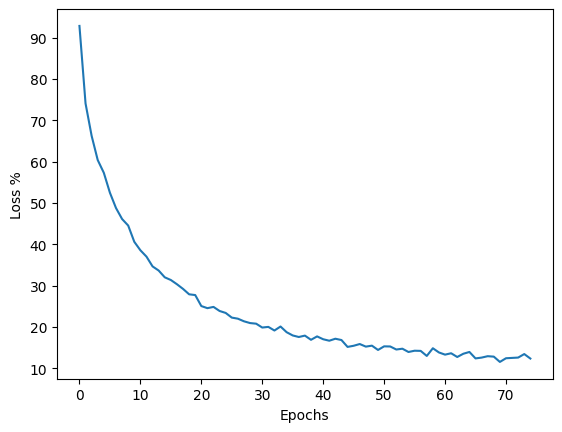

In [21]:
# plt.plot(loss_over_epochs)
loss = []
for i in range(len(loss_over_epochs)):
    loss.append(loss_over_epochs[i]['ner'] / 100)

plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss %')
plt.show()

In [22]:
%%skip_if skip_spacy_model
nlp_updated = spacy.load("spacy_ner_v1.0")
text = "HISTORY:,  A 55-year-old female presents self-referred for the possibility of evaluation and treatment of allergies, diminished taste, xerostomia, gastroesophageal reflux disease, possible food allergies, chronic GI irritability, asthma, and environmental inhalant allergies."
doc = nlp_updated(text)
print(doc)
print([(ent.text, ent.label_) for ent in doc.ents])


HISTORY:,  A 55-year-old female presents self-referred for the possibility of evaluation and treatment of allergies, diminished taste, xerostomia, gastroesophageal reflux disease, possible food allergies, chronic GI irritability, asthma, and environmental inhalant allergies.
[('55-year-old', 'B-TOOL'), ('allergies', 'B-COND'), ('diminished', 'B-SYM'), ('taste', 'I-SYM'), ('gastroesophageal', 'B-COND'), ('reflux', 'I-COND'), ('disease', 'I-COND'), ('food', 'B-AP'), ('allergies', 'I-AP'), ('irritability', 'I-AP'), ('asthma', 'B-COND')]


<ExecutionResult object at 7f47a1e16390, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f47a1e160f0, raw_cell="nlp_updated = spacy.load("spacy_ner_v1.0")
text = .." transformed_cell="nlp_updated = spacy.load("spacy_ner_v1.0")
text = .." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### Metrics - SPACY model
Typical metrics for classification tasks are Confusion Matrices which measure the accuracy, error and F1 score of a model. Traditionally, these measures are taken as a "complete" comparison of the entire prediction w.r.t the original input. However, it should be noted that in the case of NER, the model's accuracy can be better measured by comparing the prediction of individual tokens rather than the map as a whole.
To account for this, a custom metric measurement function was creatd per below. This metric function compares each token predicted against the original value to determine if it is:
* True Positive: If predicted tag == original tag.
* False Positive: If predicted tag is a valid label that is not the "Outside" label even if the original label was an "Outside" label.
* True Negative: If predicted tag != original tag and original tag is not "Outside" label.
* False Negative: If predicted tag is a non-outside label, and the original label was marked as "Outside".


In [ ]:


def init_metric_dict(metric_dict):
    metric_dict['tp'] = 0
    metric_dict['fp'] = 0
    metric_dict['fn'] = 0
    metric_dict['tn'] = 0
    return metric_dict


In [200]:
def string_to_list_of_tuples(input_string):
  try:
    result = ast.literal_eval(input_string)
    if isinstance(result, list) and all(isinstance(item, tuple) for item in result):
      return result
    else:
      raise ValueError("Input string is not a valid list of tuples.")
  except (ValueError, SyntaxError) as e:
    print(input_string)
    raise ValueError(f"Error converting string to list of tuples: {e}")

def count_errors(filt_orig_tuple_list, pred_tuple_list, orig_tuple_list, metric_dict):
  for orig_tuple, pred_tuple in zip(filt_orig_tuple_list, pred_tuple_list):
    if (orig_tuple[1] == pred_tuple[1]):
      metric_dict['tp'] += 1
    elif (orig_tuple[1] !='O' and pred_tuple[1] != 'O'):
      metric_dict['fp'] += 1
    elif (pred_tuple[1] == 'O' and orig_tuple[1] != 'O'):
      metric_dict['fn'] += 1
  
  metric_dict['tn'] += (len(orig_tuple_list) - abs(len(filt_orig_tuple_list) - len(pred_tuple_list)))
  return metric_dict


In [199]:
def plot_metrics(metric_array, metrics):
    plt.matshow(metric_array.reshape((2, 2)))
    plt.xlabel("Predicted Value")
    plt.xticks(ticks = [0, 1], labels=["True", "False"])
    plt.yticks(ticks = [0, 1], labels=["True", "False"])
    plt.ylabel("Actual Value")
    plt.colorbar()

    accuracy = (metrics['tp'] + metrics['tn'])/ (metrics['tp'] + metrics ['fp'] + metrics['fn'] + metrics['tn'])
    precision = metrics['tp'] / (metrics['tp'] + metrics ['fp'])
    sensitivity = metrics['tp'] / (metrics['tp'] + metrics ['fn'])
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    print(f"TP = {metrics['tp']}\tFN = {metrics['fn']}")
    print(f"FP = {metrics['fp']}\tTN = {metrics['tn']}")
    print(f"Accuracy = {accuracy}\nPrecision = {precision}\nSensitivity (aka Recall) = {sensitivity}\nF1-score = {f1_score}")

TP = 1742	FN = 0
FP = 1877	TN = 15435
Accuracy = 0.9014905006822714
Precision = 0.4813484387952473
Sensitivity (aka Recall) = 1.0
F1-score = 0.6498787539638127


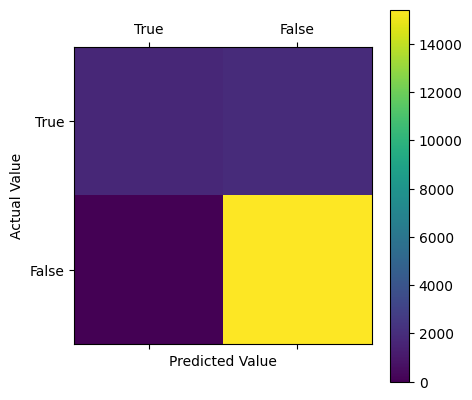

In [202]:
metric_dict_spacy = dict()
metric_dict_spacy = init_metric_dict(metric_dict_spacy)

def calc_confusion_matrix_spacy():
    for _, row in test_df.iterrows():
        orig_text = row['sentence']
        orig_list_of_tuples_as_str = row['annotated_sentence']
        doc = nlp_med(orig_text)
        
        orig_list_of_tuples = string_to_list_of_tuples(orig_list_of_tuples_as_str)
        filt_orig_list_of_tuples = [tup for tup in orig_list_of_tuples if tup[1] != 'O']
        pred_list_of_tuples = [(str(ent), ent.label_) for ent in doc.ents]   
        count_errors(filt_orig_list_of_tuples, pred_list_of_tuples, orig_list_of_tuples, metric_dict_spacy)

    np_metric_array = np.array(list(metric_dict_spacy.values()))
    plot_metrics(np_metric_array, metric_dict_spacy)

calc_confusion_matrix_spacy()


## Summary
Based on the above, we see that Spacy has a compelling approach towards building an NER model.
* Highlights of the Model:
    * Easy to build
    * Primary focus on creating dataset aligned to the Spacy format - but easy once we have a BIO annotated dataset.
    * Training iterations are easy and extensible.
    * More improvements in newer Spacy Models where the above is rolled into more NLP pipelines including relationship extraction
    * Model shows high accuracy (~90%)
* Lowlights:
    * Current model does not include distinction between BIO tags separately (Newer versions of spacy can utilise BIO tags separately from labels).
    * Model shows low precision (~60%)
* F1-score = 0.64. Given that this is greater than 0.5, indicates that the model performs reasonably well and while the model can miss classifying information that could potentially be classed, any classes that are identified can be relied on. 

# BERT Model

## Dataset creation
For this model, we will use the Transformers models to build from a pre-trained BERT model. Given this approach, we will first need to convert the data that we have on hand into a Transformers Dataset. For the NER task, there are certain aspects needed for the dataset. These include identifying the key features for this token classification problem. Hence the data set has the following features:
1. An identifier for each element of the Dataset.
2. Specific NER Tags taht are identified by the list of labels that we identified.
3. Tokenized value of the string.

In [109]:
%%skip_if skip_bert_model
import re
from datasets import Dataset, Features, Value, ClassLabel, Sequence
import string

# Example for a text classification dataset
ner_tag_features = Features({
    'id': Value('int32'),
    'ner_tags': Sequence(ClassLabel(names=['O', 'B-AP', 'I-AP', 'B-SYM', 'I-SYM','B-COND', 'I-COND', 'B-PROC', 'I-PROC', 'B-MED', 'I-MED', 'B-TOOL', 'I-TOOL'])),
    'tokens': [Value('string')]  
})

def extract_ner_token_pairs(sentence, id, ignore_punctuation_and_stop_words=False):
    sentenced_ner_token_dict = []
        
    sample_dict = {}
    ner_tag_list = []
    token_list = []

    matches = re.findall(r"\((.*?)\)" , sentence)
    for match in matches:
        ner_token_pair = re.findall(r'\"(.*?)\"', match)
        if (len(ner_token_pair) == 0):
            ner_token_pair = re.findall(r'\'(.*?)\'', match)

        if (len(ner_token_pair) == 0):
            continue

        word = ner_token_pair[0].lower()

        if (ignore_punctuation_and_stop_words == True):
            if (len(word) == 1 and any(char in string.punctuation for char in word)):
                continue
            if (word in english_stopwords):
                continue
        try:
            index = label_list.index(ner_token_pair[1])
            label = ner_token_pair[1]
        except ValueError:
            index = 0
            label = 'O'

        if word is None or index is None:
            continue
        token_list.append(word)
        ner_tag_list.append(index)

    if (len(ner_tag_list)>= 1):
        sample_dict.update([('id', str(id)), ('ner_tags', ner_tag_list), ('tokens', token_list)])
        id = id+1
        sentenced_ner_token_dict.append(sample_dict)
    
    return sentenced_ner_token_dict, id

def get_ner_tokens_as_ds(df, ignore_punctuations_and_stop_words = False):
    ner_tok_dict=[]
    last_id = 0
    for i in range(len(df)):
        sentenced_token_dict, last_id = extract_ner_token_pairs(df.loc[i], last_id, ignore_punctuations_and_stop_words)
        for element in sentenced_token_dict:
            ner_tok_dict.append(element)
    temp_df = pd.DataFrame(ner_tok_dict)
    temp_df.replace(' ', np.nan, inplace=True)
    ds = Dataset.from_pandas(temp_df, features=ner_tag_features)
    return ds

train_ds = get_ner_tokens_as_ds(train_df_NER)
print("\nTraining Dataset:\n", train_ds)
print("Sample training data:\n\t", train_ds[0])

test_ds = get_ner_tokens_as_ds(test_df_NER)
print("\nTest Dataset:\n", test_ds)
print("Sample test data:\n\t", test_ds[0])



Training Dataset:
 Dataset({
    features: ['id', 'ner_tags', 'tokens'],
    num_rows: 1607
})
Sample training data:
	 {'id': 0, 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0], 'tokens': ['subjective', ':', ',', 'this', '23-year-old', 'white', 'female', 'presents', 'with', 'complaint', 'of', 'allergies', '.']}

Test Dataset:
 Dataset({
    features: ['id', 'ner_tags', 'tokens'],
    num_rows: 792
})
Sample test data:
	 {'id': 0, 'ner_tags': [0, 11, 0, 0, 0, 0, 0, 1, 0], 'tokens': ['the', 'hemostat', 'was', 'then', 'passed', 'through', 'the', 'incision', '.']}


<ExecutionResult object at 7f476b347ad0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f476b347aa0, raw_cell="import re
from datasets import Dataset, Features, .." transformed_cell="import re
from datasets import Dataset, Features, .." store_history=False silent=False shell_futures=True cell_id=None> result=None>

## Tokenization
For the BERT model to operate, it is important to tokenize and enumerate

In [111]:
%%skip_if skip_bert_model

from transformers import AutoTokenizer, BertTokenizerFast
example = train_ds[97]
labels_list = train_ds.features[f"ner_tags"].feature.names
print(labels_list)
tokenizer = BertTokenizerFast.from_pretrained("dmis-lab/biobert-v1.1")
print("Tokens: ", example["tokens"])
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
print("Tokenized input: ", tokenized_input)
# print(len(example["tokens"]))

tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print("Tokens converted back from ids:", tokens)

word_ids = tokenized_input.word_ids()
print("Word_ids: ", word_ids)
word_tags = []
for i, label in enumerate (example[f"ner_tags"]):
    print("Enumeration:", i, label, labels_list[label])
    word_tags.append(label)

label_ids=[]
previous_word_idx = None
for word_idx in word_ids:
    if word_idx is None:
        label_ids.append(-100)
    else:
        label_ids.append(word_tags[word_idx])
print(label_ids)
tokenized_input["labels"] = label_ids
print("Tokenized_input:", tokenized_input)

['O', 'B-AP', 'I-AP', 'B-SYM', 'I-SYM', 'B-COND', 'I-COND', 'B-PROC', 'I-PROC', 'B-MED', 'I-MED', 'B-TOOL', 'I-TOOL']
Tokens:  ['normal', 'lv', 'diastolic', 'function', '.', ',', '5', '.']
Tokenized input:  {'input_ids': [101, 2999, 181, 1964, 4267, 12788, 14987, 3053, 119, 117, 126, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Tokens converted back from ids: ['[CLS]', 'normal', 'l', '##v', 'di', '##ast', '##olic', 'function', '.', ',', '5', '.', '[SEP]']
Word_ids:  [None, 0, 1, 1, 2, 2, 2, 3, 4, 5, 6, 7, None]
Enumeration: 0 0 O
Enumeration: 1 1 B-AP
Enumeration: 2 2 I-AP
Enumeration: 3 2 I-AP
Enumeration: 4 0 O
Enumeration: 5 0 O
Enumeration: 6 0 O
Enumeration: 7 0 O
[-100, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, -100]
Tokenized_input: {'input_ids': [101, 2999, 181, 1964, 4267, 12788, 14987, 3053, 119, 117, 126, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1,

<ExecutionResult object at 7f476a8c3dd0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f476a8c2540, raw_cell="
from transformers import AutoTokenizer, BertToken.." transformed_cell="from transformers import AutoTokenizer, BertTokeni.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### Align labels
Tokenization typically involves breaking words into different tokens which includes sub-tokens. It is important to align this token with the right tag as part of Dataset preparation for the training step. The below function and the subsequent calls allow for the same.

In [112]:
%%skip_if skip_bert_model

def tokenize_and_align_labels(example):
    tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
    tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
    word_ids = tokenized_input.word_ids()
    word_tags = []
    for i, label in enumerate (example[f"ner_tags"]):
        word_tags.append(label)

    label_ids=[]
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        else:
            label_ids.append(word_tags[word_idx])
    tokenized_input["labels"] = label_ids
    return tokenized_input


<ExecutionResult object at 7f476554e2d0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f476554e5a0, raw_cell="
def tokenize_and_align_labels(example):
    token.." transformed_cell="def tokenize_and_align_labels(example):
    tokeni.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [113]:
tokenized_train = train_ds.map(tokenize_and_align_labels, batched=False)
tokenized_test = test_ds.map(tokenize_and_align_labels, batched=False)
print(tokenized_train)
print(tokenized_test)
# for i in range(len(tokenized_train['ner_tags'][0])):
#     print(tokenized_train['ner_tags'][0][i], ":", tokenized_train['tokens'][0][i])

Map:   0%|          | 0/1607 [00:00<?, ? examples/s]

Map:   0%|          | 0/792 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'ner_tags', 'tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1607
})
Dataset({
    features: ['id', 'ner_tags', 'tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 792
})


## Pre-training dataset distribution analysis
For training with the BERT model, it is important to have a good balanced distribution of the dataset. We hence inspect the distribution of labels in the training dataset and the testing dataset. 


In [153]:
from collections import Counter

# Inspect class distribution
train_labels = [label for sample in train_ds["ner_tags"] for label in sample]
counts = Counter(train_labels)
train_label_counts = dict(sorted(counts.items()))
print("Class distribution:", train_label_counts)

test_labels = [label for sample in test_ds["ner_tags"] for label in sample]
counts = Counter(test_labels)
test_label_counts = dict(sorted(counts.items()))
print("Class distribution:", test_label_counts)

Class distribution: {0: 23430, 1: 2141, 2: 1831, 3: 166, 4: 129, 5: 515, 6: 446, 7: 498, 8: 371, 9: 273, 10: 217, 11: 506, 12: 400}
Class distribution: {0: 12275, 1: 1176, 2: 1050, 3: 53, 4: 24, 5: 225, 6: 159, 7: 329, 8: 260, 9: 204, 10: 167, 11: 334, 12: 291}


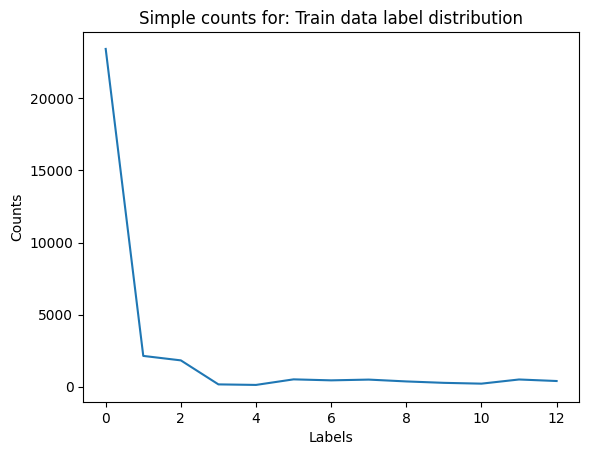

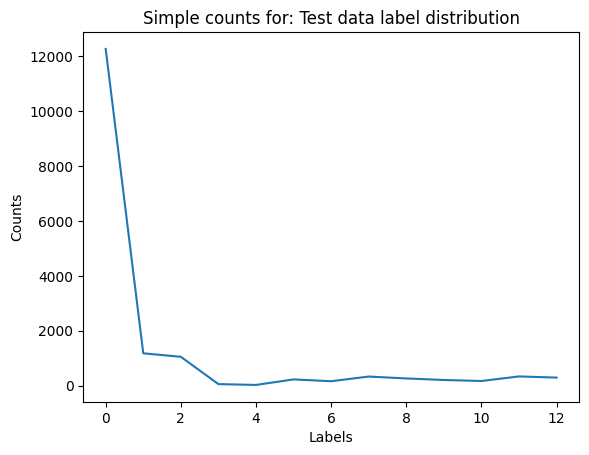

In [169]:
import matplotlib.pyplot as plt

def plot_data_counts(counts, title):
	sorted_counts = dict(sorted(counts.items()))
	labels = list(sorted_counts.keys())
	label_counts = list(sorted_counts.values())
	plt.plot(labels, label_counts)
	plt.xlabel('Labels')
	plt.ylabel('Counts')
	plt.title('Simple counts for: ' + title)
	plt.show()


plot_data_counts(train_label_counts, "Train data label distribution")
plot_data_counts(test_label_counts, "Test data label distribution")

# count_all_labels(labels, train_corpus, "Training Data")
# count_all_labels(labels, dev_corpus, "Development Data")

From the above plots, it can be noted that on first glance, the dataset looks like it is unbalanced with a lot more skew towards "Outside" tag data. However, this information is actually useful as it allows the models to not mis-classify items like punctuations and conjunctions into named entities.

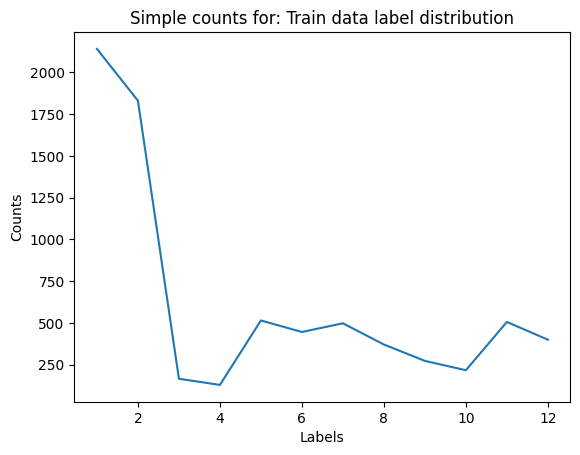

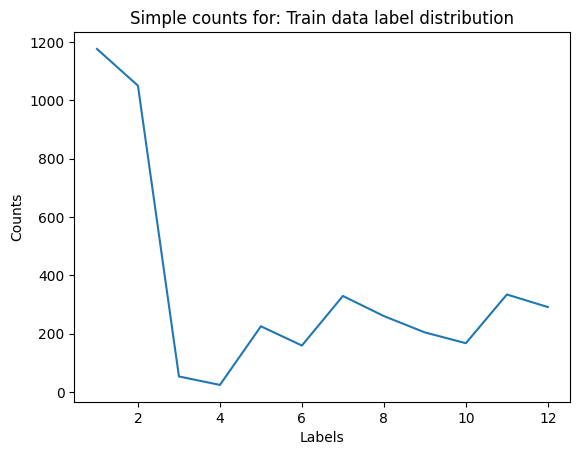

In [170]:
train_label_counts_filtered = {key: train_label_counts[key] for key in train_label_counts if key != 0}
plot_data_counts(train_label_counts_filtered, "Train data label distribution")

test_label_counts_filtered = {key: test_label_counts[key] for key in test_label_counts if key != 0}
plot_data_counts(test_label_counts_filtered, "Train data label distribution")

From the above plots, it can be noted that the dataset without the "Outside" tag is more balanced. However, as mentioned earlier, we will retain the "Outside" tags as-is to allow for the model to recognize and avoid mis-classifying items like punctuations and conjunctions into named entities.

## Model Description
In this attempt, we will use the pre-trained BIO-BERT model, with fine tuning of the NER tags to include the specific labels that we have. Unlike the SPACY model, we will explicitly include the BI tags and the Outside Tag for this model. Most of the model configuration will remain unchanged as shown in the model configuration output below. However, there will be some customization of a few hyper parameters (explained in subsequent cells)

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(
    "dmis-lab/biobert-v1.1", num_labels=len(label_list), id2label=id2label, label2id=label2id
)

print(model.config)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-AP",
    "2": "I-AP",
    "3": "B-SYM",
    "4": "I-SYM",
    "5": "B-COND",
    "6": "I-COND",
    "7": "B-PROC",
    "8": "I-PROC",
    "9": "B-MED",
    "10": "I-MED",
    "11": "B-TOOL",
    "12": "I-TOOL"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-AP": 1,
    "B-COND": 5,
    "B-MED": 9,
    "B-PROC": 7,
    "B-SYM": 3,
    "B-TOOL": 11,
    "I-AP": 2,
    "I-COND": 6,
    "I-MED": 10,
    "I-PROC": 8,
    "I-SYM": 4,
    "I-TOOL": 12,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype":

In [173]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
import evaluate

seqeval = evaluate.load("seqeval")

In [174]:
import numpy as np

labels = [label_list[i] for i in example[f"ner_tags"]]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

#### Training with hyper parameters
For this model, we will use the Transforers architecture with. As mentioned earlier, the BIO-BERT model is fine tuned to include the labels for this specific NER task. We set the learning rate to be 2e-5 an have a decay of 1%.  The model is trained over 10 epochs and from the losses table, it can be noted that we stop before too many iterations lead to any form of overfit.

Finally, the model is pushed to the Transformers hub for open use by others in the future (bsr-1239789/ner_model).

In [176]:
training_args = TrainingArguments(
    output_dir="bsr-123789/ner_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    warmup_ratio=0.01,
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.707860,0.496245,0.522107,0.508848,0.786451
2,No log,0.578649,0.618592,0.583443,0.600503,0.821806
3,No log,0.555012,0.632668,0.638382,0.635512,0.834565
4,No log,0.572232,0.653824,0.628975,0.641158,0.835252
5,0.594600,0.587388,0.626221,0.663217,0.644189,0.832589
6,0.594600,0.595142,0.625706,0.666792,0.645596,0.834006
7,0.594600,0.610591,0.634702,0.660019,0.647113,0.835596
8,0.594600,0.625936,0.625990,0.668862,0.646716,0.834135
9,0.594600,0.640207,0.626681,0.666416,0.645938,0.833276
10,0.204800,0.650605,0.626657,0.675823,0.650312,0.833835


/mnt/c/Praroha/Code/AI574/project/pocs/NER/.ner_venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1010, training_loss=0.3973279647307821, metrics={'train_runtime': 298.1674, 'train_samples_per_second': 53.896, 'train_steps_per_second': 3.387, 'total_flos': 679333479270126.0, 'train_loss': 0.3973279647307821, 'epoch': 10.0})

In [177]:
trainer.push_to_hub()

Uploading...:   0%|          | 0.00/431M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bsr-123789/ner_model/commit/7ab4b2abeec5d48b0b002e35b1ec9a36bf7e6f0c', commit_message='End of training', commit_description='', oid='7ab4b2abeec5d48b0b002e35b1ec9a36bf7e6f0c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bsr-123789/ner_model', endpoint='https://huggingface.co', repo_type='model', repo_id='bsr-123789/ner_model'), pr_revision=None, pr_num=None)

## Metrics - BERT Model
Similar to the SPACY Model, we will again use the typical metrics for classification tasks, i.e., Confusion Matrices which measure the accuracy, error and F1 score of a model. Traditionally, these measures are taken as a "complete" comparison of the entire prediction w.r.t the original input. This is the same as the "compute_metrics()" routine provided as part of the model earlier. However, it should be noted that in the case of NER, the model's accuracy can be better measured by comparing the prediction of individual tokens rather than the map as a whole.

To account for this, a custom metric measurement function was creatd per below. This metric function compares each token predicted against the original value to determine if it is:
* True Positive: If predicted tag == original tag.
* False Positive: If predicted tag is a valid label that is not the "Outside" label even if the original label was an "Outside" label.
* True Negative: If predicted tag != original tag and original tag is not "Outside" label.
* False Negative: If predicted tag is a non-outside label, and the original label was marked as "Outside".

In [66]:
def get_predicted_words_and_tags_as_tuples(original_text, prediction):
    tokenized_words = []
    tokenized_entities = []
    for i in range(len(prediction)):
        tokenized_words.append(prediction[i]['word'])
    pred_tags = []
    pred_words = []
    next_word_idx = 0
    for i in range(len(prediction)):
        if prediction[i]['word'].startswith("##"):
            if next_word_idx == 0:
                pred_words.append(prediction[i]['word'].removeprefix("##"))
            else:
                pred_words[next_word_idx - 1]+=prediction[i]['word'].removeprefix("##")
        else:
            pred_words.append(prediction[i]['word'])
            pred_tags.append(prediction[i]['entity'])
            next_word_idx += 1
    predicted_words_and_tags = list(zip(pred_words, pred_tags))
    return predicted_words_and_tags

### Example prediction

In [220]:
from transformers import pipeline
sample_text = "HISTORY:,  A 55-year-old female presents self-referred for the possibility of evaluation and treatment of allergies, diminished taste, xerostomia, gastroesophageal reflux disease, possible food allergies, chronic GI irritability, asthma, and environmental inhalant allergies.  Please refer to chart for history and physical and review of systems and detailed medical history."
classifier = pipeline("ner", model="bsr-123789/ner_model")
predicted_output = classifier(sample_text)
print(type(predicted_output), predicted_output)
mapped_words_with_tags = get_predicted_words_and_tags_as_tuples(sample_text, predicted_output)
print(mapped_words_with_tags)

Device set to use cuda:0


<class 'list'> [{'entity': 'B-COND', 'score': 0.7988544, 'index': 27, 'word': 'all', 'start': 106, 'end': 109}, {'entity': 'B-COND', 'score': 0.78144383, 'index': 28, 'word': '##er', 'start': 109, 'end': 111}, {'entity': 'B-COND', 'score': 0.7179022, 'index': 29, 'word': '##gies', 'start': 111, 'end': 115}, {'entity': 'B-COND', 'score': 0.42874146, 'index': 31, 'word': 'diminished', 'start': 117, 'end': 127}, {'entity': 'B-COND', 'score': 0.252745, 'index': 32, 'word': 'taste', 'start': 128, 'end': 133}, {'entity': 'B-COND', 'score': 0.6379553, 'index': 34, 'word': 'x', 'start': 135, 'end': 136}, {'entity': 'B-COND', 'score': 0.6839944, 'index': 35, 'word': '##ero', 'start': 136, 'end': 139}, {'entity': 'B-COND', 'score': 0.6489701, 'index': 36, 'word': '##sto', 'start': 139, 'end': 142}, {'entity': 'B-COND', 'score': 0.55138844, 'index': 37, 'word': '##mia', 'start': 142, 'end': 145}, {'entity': 'B-COND', 'score': 0.7831658, 'index': 39, 'word': 'gas', 'start': 147, 'end': 150}, {'ent

Device set to use cuda:0


TP = 2037	FN = 0
FP = 1816	TN = 15408
Accuracy = 0.9057162141114169
Precision = 0.5286789514663899
Sensitivity (aka Recall) = 1.0
F1-score = 0.6916808149405773


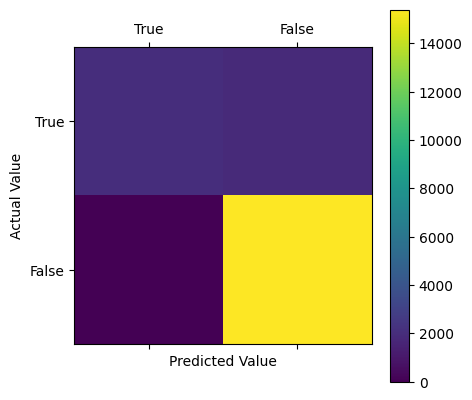

In [224]:
metric_dict_bert = dict()
metric_dict_bert = init_metric_dict(metric_dict_bert)
classifier = pipeline("ner", model="bsr-123789/ner_model")

def calc_confusion_matrix_bert():
    for _, row in test_df.iterrows():
        orig_text = row['sentence']
        orig_list_of_tuples_as_str = row['annotated_sentence']
        predicted_output = classifier(orig_text)
        pred_list_of_tuples = get_predicted_words_and_tags_as_tuples(orig_text, predicted_output)
        orig_list_of_tuples = string_to_list_of_tuples(orig_list_of_tuples_as_str)
        filt_orig_list_of_tuples = [tup for tup in orig_list_of_tuples if tup[1] != 'O']
        count_errors(filt_orig_list_of_tuples, pred_list_of_tuples, orig_list_of_tuples, metric_dict_bert)

    np_metric_array = np.array(list(metric_dict_bert.values()))
    plot_metrics(np_metric_array, metric_dict_bert)

calc_confusion_matrix_bert()

## Summary
Based on the above, we see that fine-tuned Bio-BERT model has a compelling approach towards building an NER model.
* Highlights of the Model:
    * Pre-built and annotated dataset oriented towards biology terms
    * Primary focus on creating dataset aligned to the Spacy format - but easy once we have a BIO annotated dataset.
    * Training iterations are easy and extensible.
    * More improvements in newer Spacy Models where the above is rolled into more NLP pipelines including relationship extraction
    * Model shows high accuracy (90.57%)
* Lowlights:
    * Model shows low precision (~52%)
* F1-score = 0.69. Given that this is greater than 0.5, indicates that the model performs reasonably well and while the model can miss classifying information that could potentially be classed, any classes that are identified can be relied on.


# Comparison between Spacy Model and Bert Model
As can be seen from the two models Spacy and BERT compare as follows:


|  Metric  | SPACY Model |  BERT Model  |
|:---------|------------:|-------------:|
| Accuracy |       90.15%|        90.57%|
| Precision|       48.13%|        52.87%|
| F-1 Score|       64.99%|        69.17%|

Based on the above, we notice that the BERT model slightly out performs the SPACY model.


# Demo for class presentation

In [71]:
# Pick a random transcript from a list of transcripts that the models have not seen
# Only 100 transcripts were used for NER. So picking something from index 250 and up.

index = np.random.randint(250, len(sample_df))
transcript_sent = sent_tokenize(sample_df.iloc[index]['transcription'])[0]
print(f"Input Sentence:\n{transcript_sent}")

# SPACY MODEL
import spacy
nlp_updated = spacy.load("spacy_ner_v1.0")
doc = nlp_updated(transcript_sent)
print("\n\nSpacy based NER Model")
print([(ent.text, ent.label_) for ent in doc.ents])

# BERT MODEL
from transformers import pipeline
print("\n\nBioBERT based finetuned NER Model")
classifier = pipeline("ner", model="bsr-123789/ner_model")
predicted_output = classifier(transcript_sent)
mapped_words_with_tags = get_predicted_words_and_tags_as_tuples(transcript_sent, predicted_output)
print(mapped_words_with_tags)

Input Sentence:
MEDICATIONS:,  None.,DESCRIPTION OF THE PROCEDURE:,  After informed consent was obtained, the patient was placed in the left lateral decubitus position and the Olympus video colonoscope was inserted through the anus and advanced in retrograde fashion for a distance of *** cm to the proximal descending colon and then slowly withdrawn.


Spacy based NER Model
[('None', 'B-MED'), ('left', 'B-AP'), ('lateral', 'I-AP'), ('decubitus', 'I-AP'), ('position', 'I-AP'), ('Olympus', 'B-AP'), ('video', 'I-AP'), ('colonoscope', 'I-TOOL'), ('retrograde', 'B-PROC'), ('fashion', 'I-PROC'), ('proximal', 'B-AP'), ('descending', 'I-AP'), ('colon', 'B-AP')]


BioBERT based finetuned NER Model


Device set to use cuda:0


[('left', 'B-AP'), ('lateral', 'I-AP'), ('decubitus', 'I-AP'), ('position', 'I-AP'), ('Olympus', 'B-TOOL'), ('video', 'B-TOOL'), ('colonoscope', 'I-TOOL'), ('anus', 'B-AP'), ('proximal', 'B-AP'), ('descending', 'I-AP'), ('colon', 'I-AP')]
